In [3]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
import numpy as np

In [4]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [5]:
def getData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    scalar.append('quark_eta')
    scalar.append('quark_theta')
    scalar.append('quark_p')
    scalar.append('quark_pt')
    
    #hadron variables
    cols.append('jt')
    cols.append('z')
    cols.append('pid')
    cols.append('pt')
    cols.append('eta')
    cols.append('rap')
    cols.append('theta')
    cols.append('p')
    
    cols.append('in_jet_pt')
    cols.append('in_jet_dphi')
    cols.append('in_jet_eta')
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

## Apply cuts

In [36]:
def applyCuts(df):
    temp = df
    temp = applyCut(temp, '0.1 < y < 0.85', '0.1 < y < 0.85')
    #temp = applyCut(temp, '0.1 < x < 0.7', '0.1 < x < 0.7')
    temp = applyCut(temp, 'abs(pid)==211 or abs(pid)==111 or abs(pid)==321', 'Keep pions and charged kaons')
    temp = applyCut(temp, 'Q2>25.0', ' Q2>25.0')
    temp = applyCut(temp, 'in_jet_pt>5', ' jet pT > 5 GeV') 
    temp = applyCut(temp, 'in_jet_dphi>2.74', ' e-jet dphi > 2.74') 
    temp.eval('in_jet_p = in_jet_pt*cosh(in_jet_eta)', inplace=True)

    return temp

In [37]:
df = {}
df['275'] = getData(['pytree_10_275GeV_25GeV2.root'])
df['100'] = getData(['pytree_10_275GeV_25GeV2.root'])

xsec = {}
ntrials = {}

xsec['275'] = np.mean(df['275']['xsec'])
ntrials['275'] = max(df['275']['ntrials'])
xsec['100'] = np.mean(df['100']['xsec'])
ntrials['100'] = max(df['100']['ntrials'])


df['275'] = applyCuts(df['275'])
df['100'] = applyCuts(df['100'])

df.keys()


Processed pytree_10_275GeV_25GeV2.root in 7.7 seconds

Processed pytree_10_275GeV_25GeV2.root in 9.0 seconds
0.1 < y < 0.85 297377  fraction kept: 57.2
Keep pions and charged kaons 248788  fraction kept: 83.7
 Q2>25.0 246791  fraction kept: 99.2
 jet pT > 5 GeV 108077  fraction kept: 43.8
 e-jet dphi > 2.74 98416  fraction kept: 91.1
0.1 < y < 0.85 297377  fraction kept: 57.2
Keep pions and charged kaons 248788  fraction kept: 83.7
 Q2>25.0 246791  fraction kept: 99.2
 jet pT > 5 GeV 108077  fraction kept: 43.8
 e-jet dphi > 2.74 98416  fraction kept: 91.1


['100', '275']

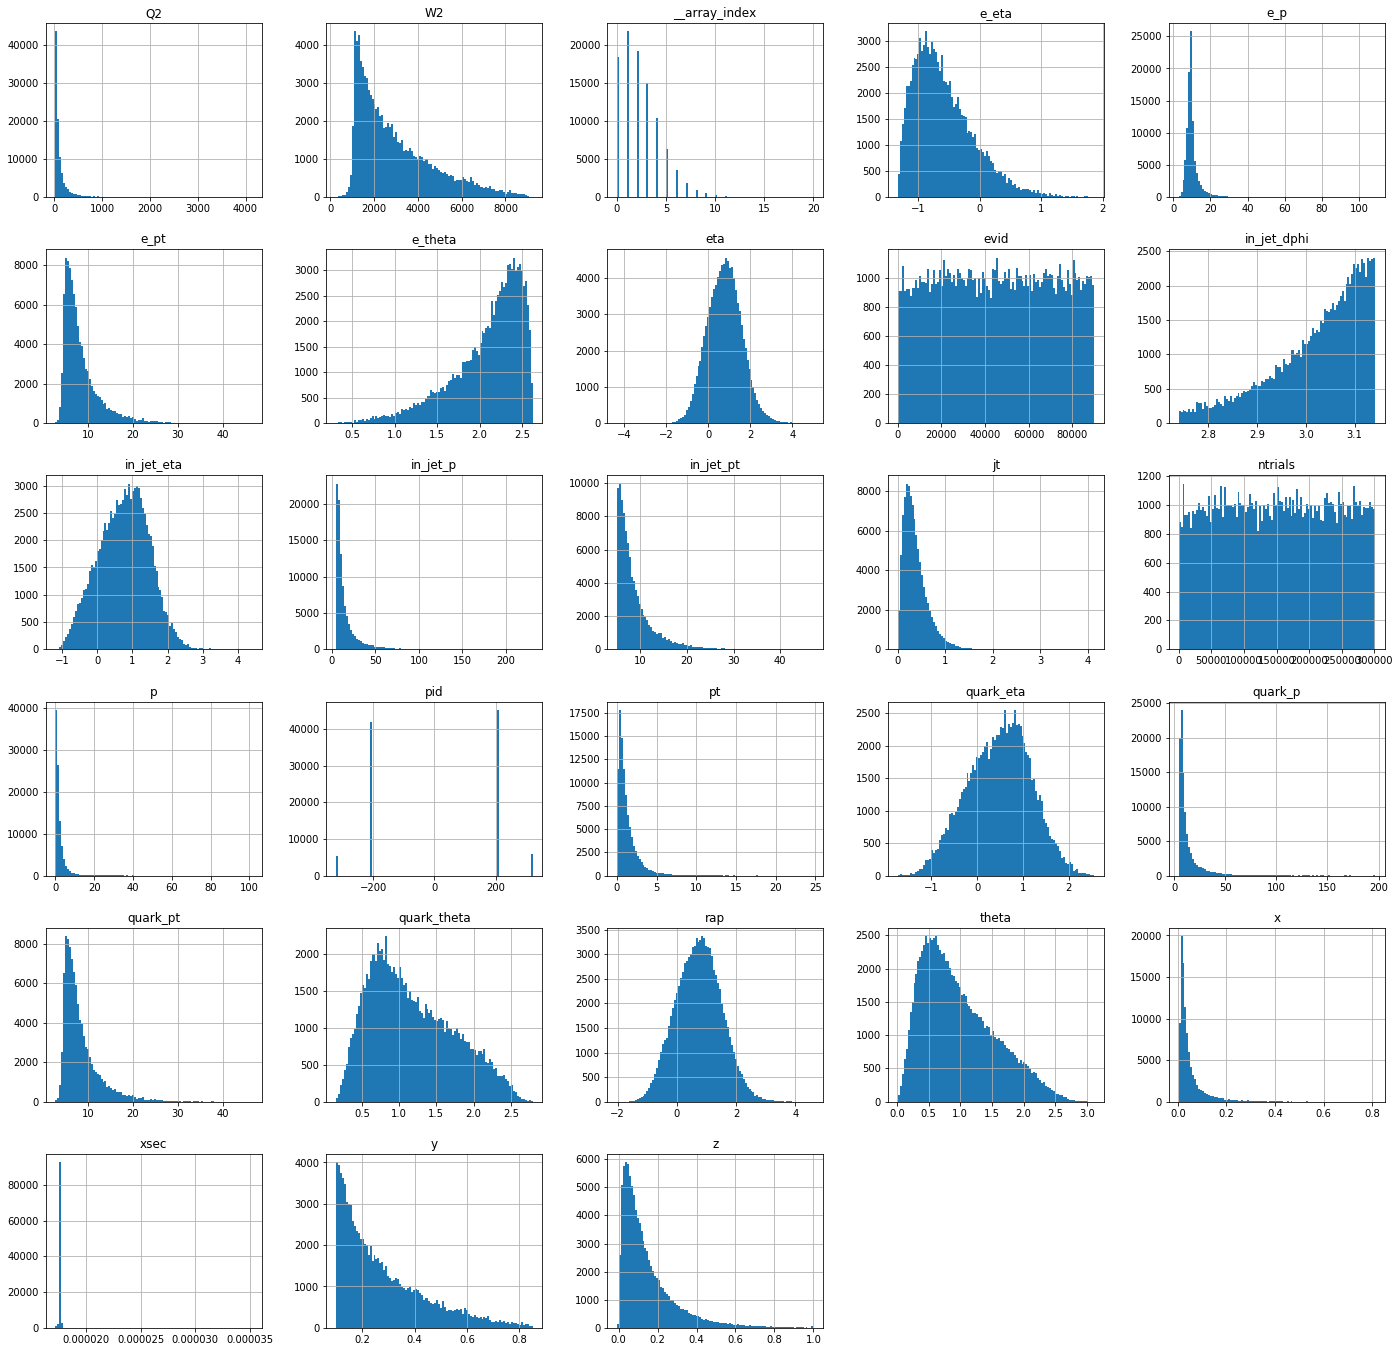

In [40]:
from matplotlib import rc
rc('text', usetex=False)
df['275'].hist(figsize=(24,24),bins=100)
plt.show()

In [70]:
jT_str = r'$j_T = |\vec{p}_{jet} \times \vec{p}_{hadron}| \left/ |\vec{p}_{jet}| \right GeV$'
z_str = r'$z = |\vec{p}_{jet} \cdot \vec{p}_{hadron}| \left/ |\vec{p}_{jet}|^2 \right.$'


## Dilution factors for statistical uncertainties in the asymmetries

In [12]:
dilution_factor = 0.7 # proton polarization x electron polarization 
efficiency = 0.5 #efficiency
penalty = 1.4 #sqrt(2) coming from separating statistically different azimuthal asymmetries
lumi = 100 # in units of fb-1. 100 is expected in a year running at 10e34. 
JES = 0.05 #jet energy scale uncertainty in percentage. 

In [62]:
max_A = 0.050
min_A = 0.001
slope = max_A-min_A
def fake_A(x,slope=max_A-min_A):
    return x*slope + min_A

## Plot to be compared with STAR result. pi+ and pi-, 0.1<x<0.2.

14.927764
37.889935
0.13758448
352.25534


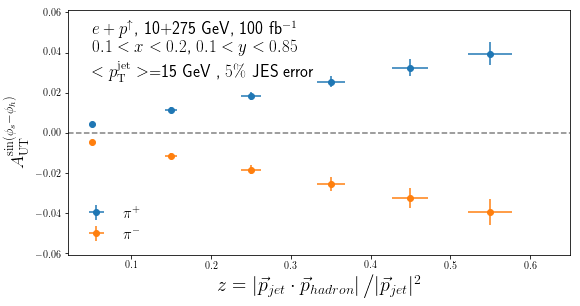

In [64]:
from matplotlib import rc
rc('text', usetex=True)
maxz = 0.6
fig = plt.figure(figsize=(9,4.5))
query = 'x>%2.2f and x<=%2.2f '%(0.1,0.2)

for dataframe in [df['100']]:
    df_cut = dataframe.query(query)
    meanQ2 = df_cut['Q2'].mean()
    print df_cut['in_jet_pt'].mean()
    print df_cut['in_jet_p'].mean()
    print df_cut['x'].mean()
    print df_cut['Q2'].mean()

    #positive pion
    y, x  = np.histogram(df_cut.query('pid==211')['z'],bins=6,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = efficiency*y
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=fake_A(x,0.07) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{+}$')
    
    #negative pion
    y, x  = np.histogram(df_cut.query('pid==-211')['z'],bins=6,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=-fake_A(x,0.07) , yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$\pi^{-}$')
    plt.axhline(y=0.0,color='black',linestyle='--',alpha=0.5)


####
plt.ylim([-0.061,0.061])
plt.xlim([0.02,0.65])

plt.text(0.05, 0.040, '$e+p^{\uparrow}$, 10+275 GeV, 100 fb$^{-1}$ \n $0.1<x<0.2$, $0.1<y<0.85$', fontsize=17)
plt.text(0.05, 0.025, '$<p_{\mathrm{T}}^{\mathrm{jet}}>$=%2.0f GeV'%df_cut['in_jet_pt'].mean() + ' , $5\%$ JES error', fontsize=17)


plt.legend(loc='lower left', fontsize=15,frameon=False,ncol=1)
plt.ylabel('$A_{\mathrm{UT}}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
plt.xlabel(z_str,fontsize=20)
plt.savefig('AUT_main_comparison.png', bbox_inches='tight')
plt.savefig('AUT_main_comparison.pdf', bbox_inches='tight')

## With Kaons

14.927764
0.13758448
352.25534


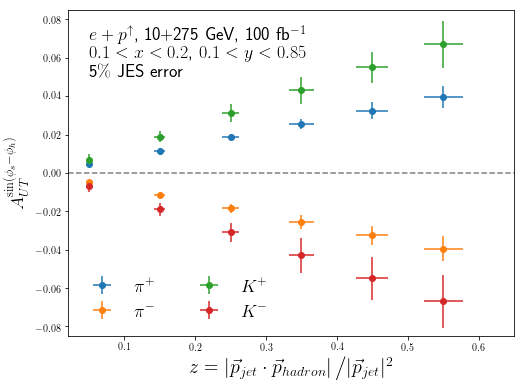

In [84]:
from matplotlib import rc
rc('text', usetex=True)
maxz = 0.6
fig = plt.figure(figsize=(8,6))
query = 'x>%2.2f and x<=%2.2f '%(0.1,0.2)

for dataframe in [df['100']]:
    df_cut = dataframe.query(query)
    meanQ2 = df_cut['Q2'].mean()
    print df_cut['in_jet_pt'].mean()
    print df_cut['x'].mean()
    print df_cut['Q2'].mean()

    #positive pion
    y, x  = np.histogram(df_cut.query('pid==211')['z'],bins=6,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = efficiency*y
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=fake_A(x,0.07) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{+}$')
    
    #negative pion
    y, x  = np.histogram(df_cut.query('pid==-211')['z'],bins=6,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=-fake_A(x,0.07) , yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$\pi^{-}$')

   
    ##K+
    y, x  = np.histogram(df_cut.query('pid==321')['z'],bins=6,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=fake_A(x,0.12) , yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$K^{+}$')

    ##K-
    y, x  = np.histogram(df_cut.query('pid==-321')['z'],bins=6,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=-fake_A(x,0.12) , yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$K^{-}$')
    
    plt.axhline(y=0.0,color='black',linestyle='--',alpha=0.5)

####
plt.ylim([-0.085,0.085])
plt.xlim([0.02,0.65])

plt.text(0.05, 0.05, '$e+p^{\uparrow}$, 10+275 GeV, 100 fb$^{-1}$\n $0.1<x<0.2$, $0.1<y<0.85$\n 5$\%$ JES error', fontsize=18)
plt.legend(loc='lower left', fontsize=18,frameon=False,ncol=2)
plt.ylabel('$A_{UT}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
plt.xlabel(z_str,fontsize=20)
plt.savefig('AUT_main.png', bbox_inches='tight')
plt.savefig('AUT_main.pdf', bbox_inches='tight')

## Hemmick plot

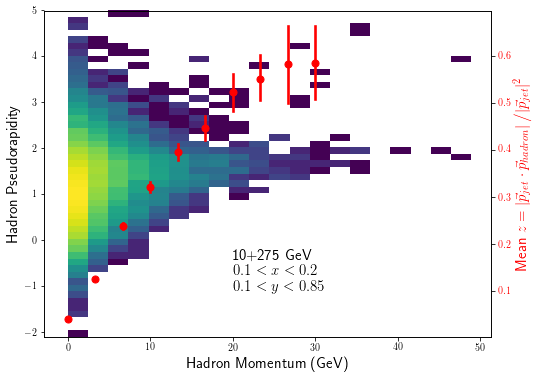

In [23]:
fig, ax1 = plt.subplots(figsize=(8,6))
import seaborn as sns
rc('text', usetex=True)

query = 'x>%2.2f and x<=%2.2f and abs(pid)==211 and e_pt>10'%(0.,0.2)

df_cut = dataframe.query(query)
plt.hist2d(df_cut['p'],df_cut['eta'], bins=(20,50),norm=LogNorm())
ax1.set_xlabel('Hadron Momentum (GeV)',fontsize=15)
ax1.set_ylabel('Hadron Pseudorapidity ',fontsize=15)

ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='red')
sns.regplot(df_cut['p'], df_cut['z'], x_bins=np.linspace(0,30,10), fit_reg=None,color='red')
ax2.set_ylabel('Mean  ' + z_str ,color='red',fontsize=15)

plt.text(20, 0.1, '10+275 GeV\n$0.1<x<0.2$ \n$0.1<y<0.85$', fontsize=15)
plt.savefig('Hemmickplot.png', bbox_inches='tight')
plt.savefig('Hemmickplot.pdf', bbox_inches='tight')

plt.show()

14.927764
0.13758448
352.25534


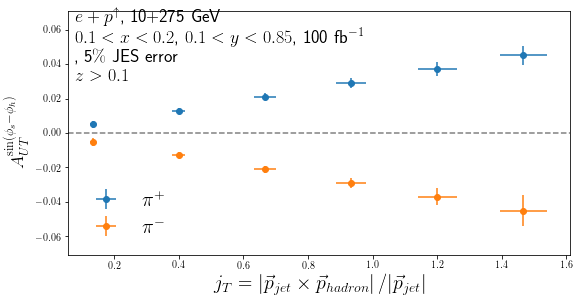

In [67]:
rc('text', usetex=True)

maxz = 1.6
fig = plt.figure(figsize=(9,4.5))
query = 'x>%2.2f and x<=%2.2f '%(0.1,0.2)

for dataframe in [df['100']]:
    df_cut = dataframe.query(query)
    meanQ2 = df_cut['Q2'].mean()
    print df_cut['in_jet_pt'].mean()
    print df_cut['x'].mean()
    print df_cut['Q2'].mean()
    y, x  = np.histogram(df_cut.query('pid==211 and z>0.1')['jt'],bins=6,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = efficiency*y
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=fake_A(x,0.03) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{+}$')
    
    y, x  = np.histogram(df_cut.query('pid==-211 and z>0.1')['jt'],bins=6,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
   
    plt.errorbar(x,y=-fake_A(x,0.03) , yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$\pi^{-}$')
    plt.axhline(y=0.0,color='black',linestyle='--',alpha=0.5)

####
plt.ylim([-0.071,0.071])
#plt.xlim([0.02,0.65])

plt.text(0.08, 0.03, '$e+p^{\uparrow}$, 10+275 GeV\n $0.1<x<0.2$, $0.1<y<0.85$, 100 fb$^{-1}$\n,$z>0.1$', fontsize=18)
plt.legend(loc='lower left', fontsize=20,frameon=False)
plt.ylabel('$A_{UT}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
plt.xlabel(jT_str,fontsize=20)
plt.savefig('AUT_main.png', bbox_inches='tight')
plt.savefig('AUT_main.pdf', bbox_inches='tight')

## Hadron-in-jets in x bins


0 0
x>0.01 and x<=0.05 
mean jet pt  7.1536713
mean jet p  10.038508
0 1
x>0.05 and x<=0.10 
mean jet pt  10.697117
mean jet p  20.919659
0 2
x>0.10 and x<=0.15 
mean jet pt  14.113766
mean jet p  34.286003
1 0
x>0.15 and x<=0.20 
mean jet pt  16.644238
mean jet p  45.48953
1 1
x>0.20 and x<=0.30 
mean jet pt  20.1224
mean jet p  60.78195
1 2
x>0.30 and x<=0.80 
mean jet pt  24.956118
mean jet p  97.43631


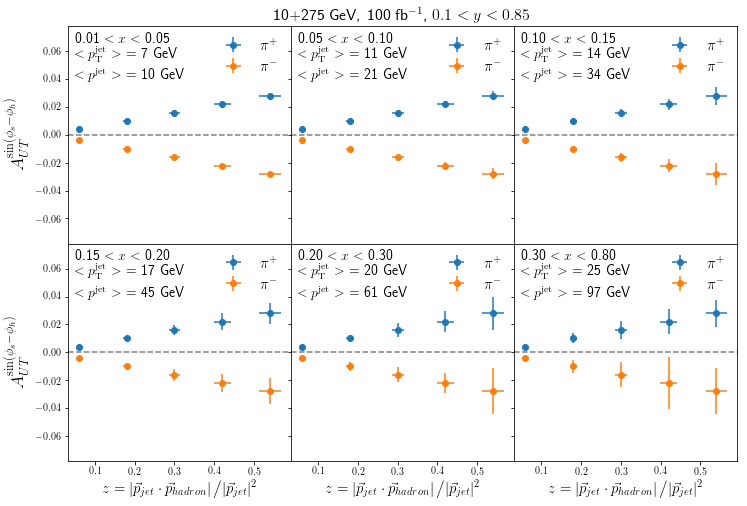

In [83]:
fig, axs = plt.subplots(2, 3,sharex=True,sharey=True, figsize=(12,8), gridspec_kw={'wspace':0, 'hspace':0.0})
Edges = [0.01,0.05,0.1, 0.15,0.2,0.3,0.8]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

maxz = 0.6
axs[0,1].set_title('10+275 GeV, 100 fb$^{-1}$, $0.1<y<0.85$',fontsize=16)

for j, ibin in enumerate(bins):
    if j<3:
        i = 0
    else:
        i= 1
        j= j%3
    print i, j
    query = 'x>%2.2f and x<=%2.2f '%(ibin[0],ibin[1])
    print query
    df_cut = df['100'].query(query)
    meanQ2 = df_cut['Q2'].mean()
    print 'mean jet pt ', df_cut['in_jet_pt'].mean()
    print 'mean jet p ', df_cut['in_jet_p'].mean()

    #pi+
    y, x  = np.histogram(df_cut.query('pid==211')['z'],bins=5,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[i,j].errorbar(x,y=fake_A(x,0.05) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{+}$')
    
    #pi-
    y, x  = np.histogram(df_cut.query('pid==-211')['z'],bins=5,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[i,j].errorbar(x,y=-fake_A(x,0.05) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{-}$')
        
    axs[i,j].legend(loc='best',fontsize=15,frameon=False)
    axs[i,j].xaxis.set_label_text(z_str,fontsize=15)
    #axs[i,j].set_title('%2.2f $<x<$ %2.2f, $<Q^{2}>$=%2.0f GeV$^{2}$'%(ibin[0],ibin[1],meanQ2), fontsize=14)    
    axs[i,j].axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
    axs[i,j].text(0.05, 0.04, '%2.2f $<x<$ %2.2f\n $<p_{\mathrm{T}}^{\mathrm{jet}}>$ = %2.0f GeV \n $<p^{\mathrm{jet}}>$ = %2.0f GeV'%(ibin[0],ibin[1],df_cut['in_jet_pt'].mean(),df_cut['in_jet_p'].mean()), fontsize=14)
    #axs[i,j].text(0.05, 0.04, '$<p^{\mathrm{jet}}>$ = %2.0f GeV'%df_cut['in_jet_p'].mean(), fontsize=14)

    
    
    
    plt.ylim([-0.078,0.078])
axs[0,0].yaxis.set_label_text('$A_{UT}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
axs[1,0].yaxis.set_label_text('$A_{UT}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
plt.savefig('AUT_projections_xbins.png', bbox_inches='tight')
plt.savefig('AUT_projections_xbins.pdf', bbox_inches='tight')